<a href="https://colab.research.google.com/github/caroheymes/Jedha-walmart-project/blob/main/01_Walmart_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://www.bestdesigns.co/uploads/inspiration_images/4350/990__1511457498_404_walmart.png" alt="WALMART LOGO" />

# Walmart : predict weekly sales

## Company's Description 📇

Walmart Inc. is an American multinational retail corporation that operates a chain of hypermarkets, discount department stores, and grocery stores from the United States, headquartered in Bentonville, Arkansas. The company was founded by Sam Walton in 1962.

## Project 🚧

Walmart's marketing service has asked you to build a machine learning model able to estimate the weekly sales in their stores, with the best precision possible on the predictions made. Such a model would help them understand better how the sales are influenced by economic indicators, and might be used to plan future marketing campaigns.

## Goals 🎯

The project can be divided into three steps:

- Part 1 : make an EDA and all the necessary preprocessings to prepare data for machine learning
- Part 2 : train a **linear regression model** (baseline)
- Part 3 : avoid overfitting by training a **regularized regression model**

## Scope of this project 🖼️

For this project, you'll work with a dataset that contains information about weekly sales achieved by different Walmart stores, and other variables such as the unemployment rate or the fuel price, that might be useful for predicting the amount of sales. The dataset has been taken from a Kaggle competition, but we made some changes compared to the original data. Please make sure that you're using **our** custom dataset (available on JULIE). 🤓

## Deliverable 📬

To complete this project, your team should: 

- Create some visualizations
- Train at least one **linear regression model** on the dataset, that predicts the amount of weekly sales as a function of the other variables
- Assess the performances of the model by using a metric that is relevant for regression problems
- Interpret the coefficients of the model to identify what features are important for the prediction
- Train at least one model with **regularization (Lasso or Ridge)** to reduce overfitting


# **Part 1 : Exploratory Data Analysis**

Setting up environment

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/08_28_walmart')

In [ ]:
# !pip install pandas-profiling==2.7.1
!pip install matplotlib==3.4



In [ ]:
!pip install missingpy
!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore") # to avoid deprecation warnings
import datetime 
from datetime import datetime , date



#Graph libraries

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
%matplotlib inline


#Preprocessing libraries
from missingpy import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  OneHotEncoder, StandardScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

#Model Selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor

from fbprophet import Prophet

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
#for classification only !
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import classification_report
# from sklearn.metrics import f1_score



In [ ]:
#Loading dataset
df = pd.read_csv('/content/drive/MyDrive/08_28_walmart/Walmart_Store_sales.csv')

# renaming columns
new_cols = [c.lower() for c in df.columns]
df = df.rename(columns=dict(zip(df.columns,new_cols)))

# Converting Dates column 
df.date = pd.to_datetime(df['date'])
df['year'] = df.date.dt.year

Weekly_Sales behavior

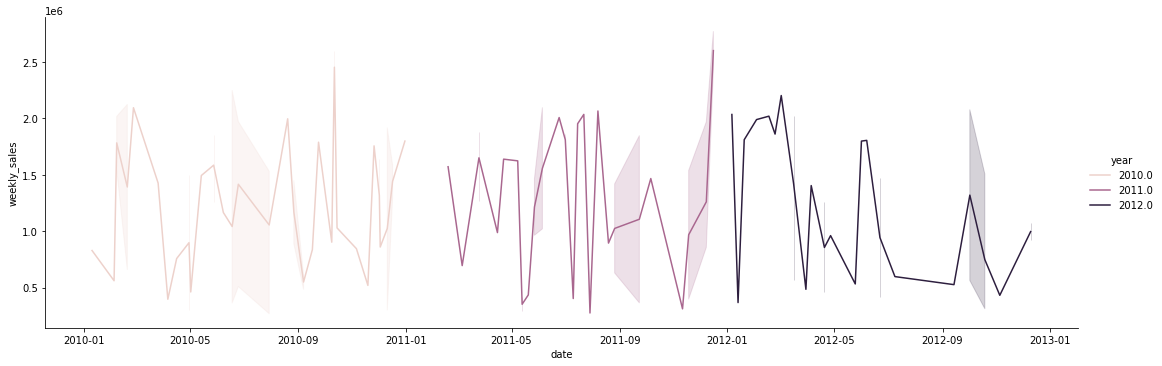

In [ ]:
sns.relplot(
        x=df['date'],
        y=df['weekly_sales'],
        hue= df['year'],
        data = df,
        kind='line',
        height=5,
        aspect=3,
       
        
    )
plt.show()

# Temporal coverage of the dataset

In [ ]:
# Determination of the temporal coverage of the dataset : 

coverage = round(100- 100*df[df.date.isna()]['weekly_sales'].sum() / df['weekly_sales'].sum())

print('We will therefore only be able to analyze {}% of the turnover'.format(coverage))


We will therefore only be able to analyze 87% of the turnover


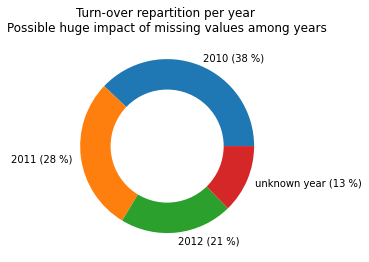

In [ ]:

df['year'] = df.year.fillna('unknown year').astype('str')
df['year'] = [str(y).replace('.0','') for y in df.year]
ca_per_year = df.groupby(['year'])[['weekly_sales']].sum()

ca_per_year.rename({'weekly_sales' : 'annual_turn_over'}, axis=1, inplace=True)
ca_per_year['(%)'] = [str(round(100 * x / ca_per_year.annual_turn_over.sum())) for x in ca_per_year.annual_turn_over]
ca_per_year = ca_per_year.reset_index().astype('str')
ca_per_year['(%)'] = ca_per_year.year + ' (' + ca_per_year['(%)'] + ' %)'

#PLotting pie chart
ax = plt.pie(ca_per_year.annual_turn_over,labels=ca_per_year['(%)']  )
centre_circle = plt.Circle((0,0),0.65,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Turn-over repartition per year \nPossible huge impact of missing values among years')
plt.show()

In [ ]:
total_turn_over = round(df['weekly_sales'].sum() / 1000000)

turn_over_year_unknown = round(df[df.year =='unknown year']['weekly_sales'].sum() / 1000000)
known_turn_over = round((total_turn_over - turn_over_year_unknown) / 1000000)

ratio_unknown = round(100* turn_over_year_unknown / total_turn_over,2)
print('******************* Disclaimer *******************')
print()
print('The cumulated turnover is {} millions US$ over 3 years. \nIt is not possible to analyze {} millions in turnover because we do not know which year to allocate, ie {}% of the total'.format(total_turn_over,turn_over_year_unknown,ratio_unknown))
print()
print('*************************************************')

******************* Disclaimer *******************

The cumulated turnover is 170 millions US$ over 3 years. 
It is not possible to analyze 22 millions in turnover because we do not know which year to allocate, ie 12.94% of the total

*************************************************


In [ ]:

# dropping lines with empty dates
df.dropna(subset = ['date'], inplace=True)


#Changing labels for holiday_flag:
df['holiday_flag'] = df.holiday_flag.map({1.0 :'bank_holidays', 0.0 : 'regular'}).fillna('unknown')

# Converting Dates column 
from datetime import datetime , date 
df.date = pd.to_datetime(df['date'])
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['month_label'] = df.date.apply(lambda x: x.strftime("%B")) 
df['day_of_week'] = df.date.apply(lambda x: x.strftime("%A"))
df['week_of_year'] = (df.date.dt.isocalendar().week)*1.0
df.shape

(132, 13)

In [ ]:
# df['date2'] = df.date.apply(lambda x: int(x.strftime("%s")))
# df[['date2']]

In [ ]:
df.sample(3)

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,year,month,month_label,day_of_week,week_of_year
22,18.0,2012-12-10,1074079.00,regular,50.97,4.029,138.911700,8.243,2012,12,December,Monday,50.0
133,1.0,2010-09-24,NaN,regular,80.94,NaN,211.597225,7.787,2010,9,September,Friday,38.0
132,4.0,2011-07-22,2036231.39,regular,82.84,3.627,129.150774,5.644,2011,7,July,Friday,29.0


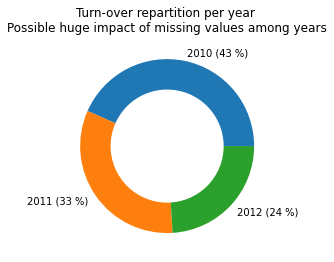

In [ ]:
ca_per_year = df.groupby(['year'])[['weekly_sales']].sum()

ca_per_year.rename({'weekly_sales' : 'annual_turn_over'}, axis=1, inplace=True)
ca_per_year['(%)'] = [str(round(100 * x / ca_per_year.annual_turn_over.sum())) for x in ca_per_year.annual_turn_over]
ca_per_year = ca_per_year.reset_index().astype('str')
ca_per_year['(%)'] = ca_per_year.year + ' (' + ca_per_year['(%)'] + ' %)'

#Plotting pie chart
ax = plt.pie(ca_per_year.annual_turn_over,labels=ca_per_year['(%)']  )
centre_circle = plt.Circle((0,0),0.65,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Turn-over repartition per year \nPossible huge impact of missing values among years')
plt.show()


# Pareto chart of monthly sales over years

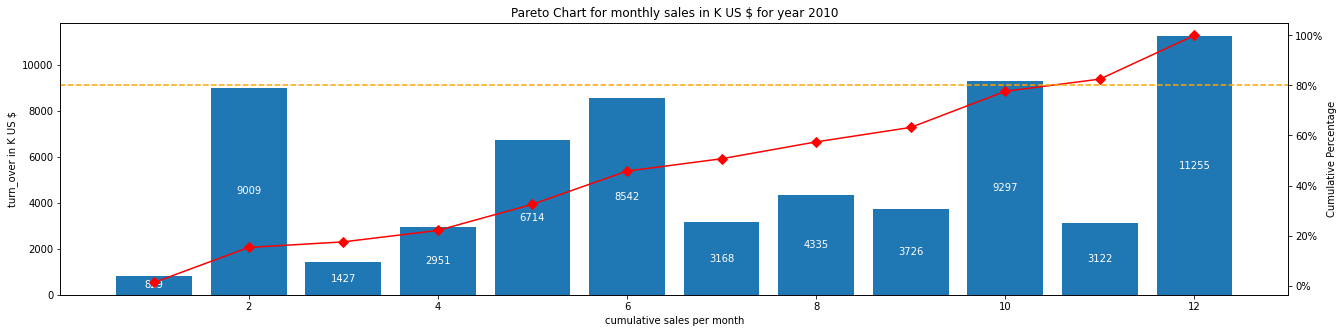

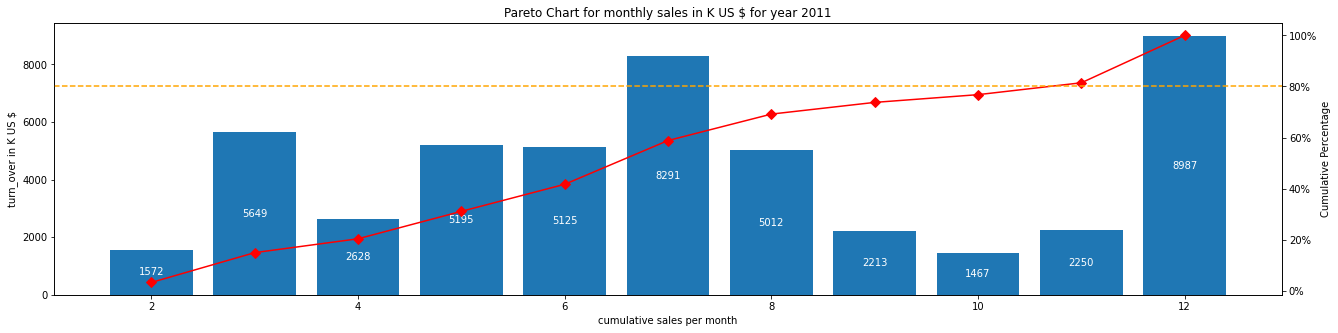

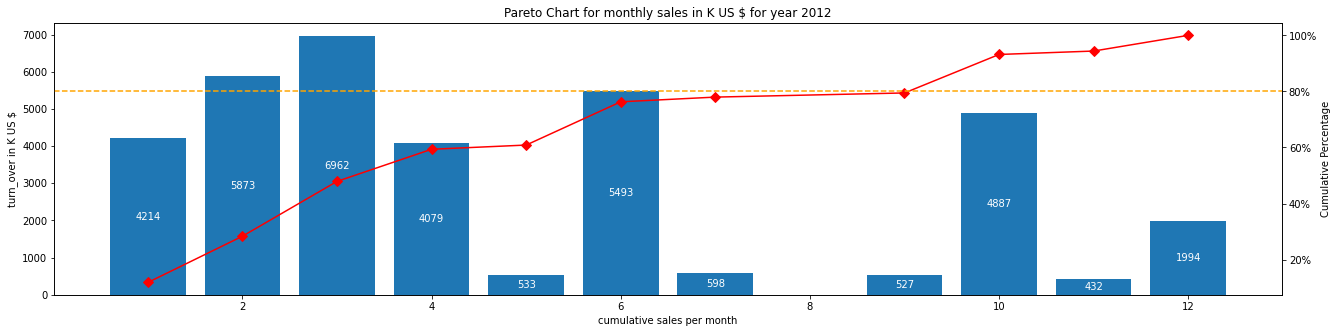

In [ ]:
#custom function to build pareto graphes
def pareto_graph(year):
  df_year =  df[df.year == year].sort_values(by=['month']).groupby(['month'])['weekly_sales'].sum().to_frame()
  df_year.weekly_sales =[round(x / 1000) for x in df_year.weekly_sales]
  df_year["cum_percentage"] = round(df_year["weekly_sales"].cumsum()/df_year["weekly_sales"].sum()*100,2)
  
  fig, ax = plt.subplots(figsize=(22,5))

  # Plot bars (i.e. frequencies)
  ax.bar(df_year.index, df_year["weekly_sales"])
  ax.set_title("Pareto Chart for monthly sales in K US $ for year {}".format(year))
  ax.set_xlabel("cumulative sales per month")
  ax.set_ylabel("turn_over in K US $");

  # Second y axis (i.e. cumulative percentage)
  ax2 = ax.twinx()
  ax2.plot(df_year.index, df_year["cum_percentage"], color="red", marker="D", ms=7)
  ax2.axhline(80, color="orange", linestyle="dashed")
  ax2.yaxis.set_major_formatter(PercentFormatter())
  ax2.set_ylabel("Cumulative Percentage")

  for c in ax.containers:
    ax.bar_label(c, label_type='center', color="white")
  plt.show()

for year in list(set(df.year)):
  pareto_graph(year) 

Is the data truely representative of the reality ?
These graphs show that the data should be treated with caution: in july and august 2010 and 2012 the turnover looks very low compared to the 2011 data. Idem for december 2012 where it appears to be 4 / 6 times lower than in 2011 /2010.

# Let's take a closer look at the data store by store

In [ ]:
# We temporarily assign a  integer data type to the stores to disply their metrics in the right order

df['store'] = [int(x) for x in df.store]


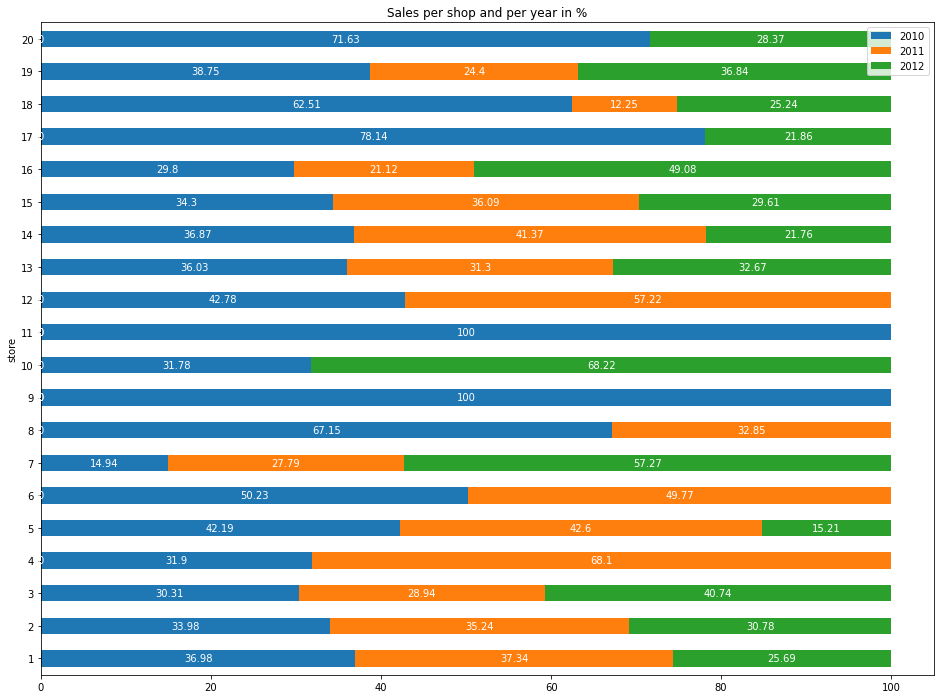

In [ ]:
df = df.sort_values('store')
s = df.groupby([df.store, df.year])['weekly_sales'].agg('sum').unstack().sort_index()
s['cumul'] = s.sum(axis=1)
s = s.apply(lambda x: round(100 * x / s.cumul,2))
s.drop(columns=['cumul'], inplace=True)
ax = s.plot(kind='barh',stacked=True, figsize=(16,12));
for c in ax.containers:
    ax.bar_label(c, label_type='center', color = 'white' )
plt.legend(loc='best')
plt.title('Sales per shop and per year in %')
plt.show()

It appears that the turnover is not equally spread over the 3 years. One may wonder if the missing years are due to a store shut-down or to a data collection problem.


Do the stores have the same level of sales?

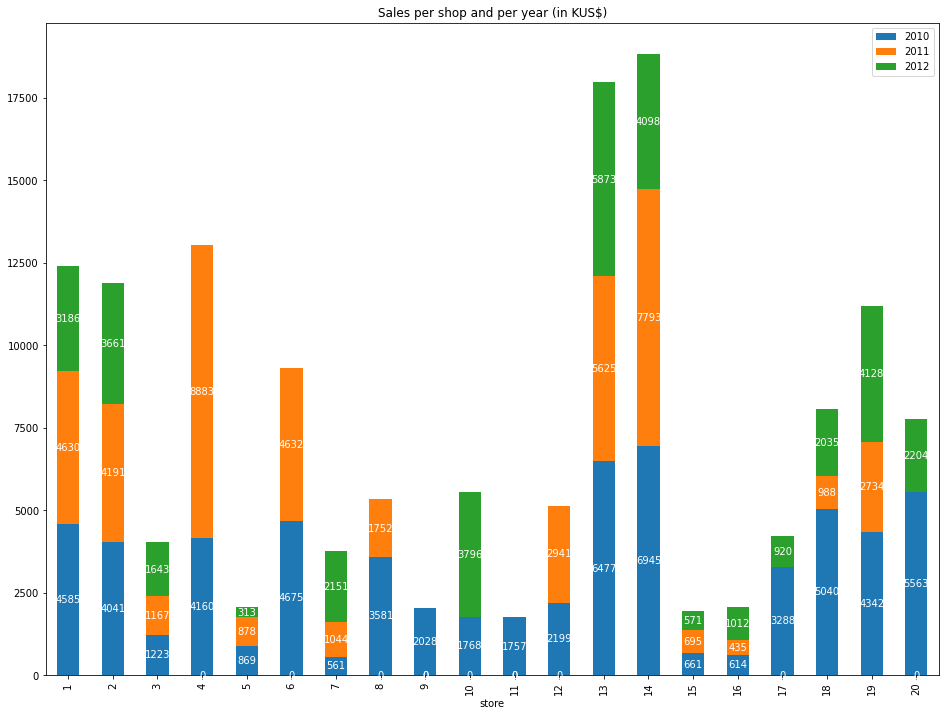

In [ ]:
#Plotting turn-over by year and by store

ax = df.groupby([df.store, df.year])['weekly_sales'].agg('sum').mul(0.001).unstack().sort_index().apply(lambda x : round(x)).plot(kind='bar',stacked=True, figsize=(16,12))
for c in ax.containers:
    ax.bar_label(c, label_type='center', color = 'white' )
plt.legend(loc='best')
plt.title('Sales per shop and per year (in KUS$)')
plt.show()

It will be interesting to investigate why some businesses have 3 times or more  turnover than others. 

2012 does not appear very preponderant in the analysis of the turnover (no notable progression compared to the previous year)


We can question the missing years for some stores: closure? unavailable data? A temporal analysis at this stage appears therefore quite problematic.

In [ ]:
df.columns

Index(['store', 'date', 'weekly_sales', 'holiday_flag', 'temperature',
       'fuel_price', 'cpi', 'unemployment', 'year', 'month', 'month_label',
       'day_of_week', 'week_of_year'],
      dtype='object')

# Distribution plot

In [ ]:
#Let's modify the type for the store column in the dataframe
df['store'] = ['store_' + str(s) for s in df.store]

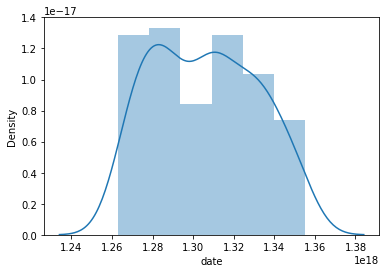

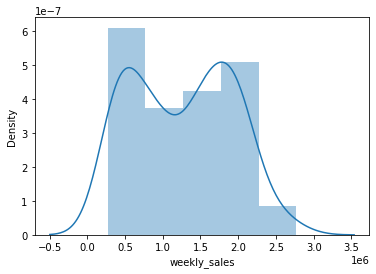

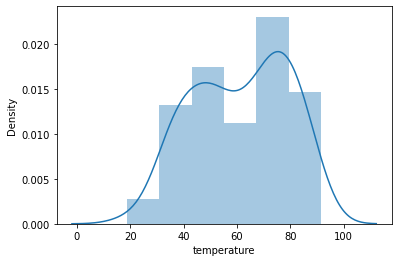

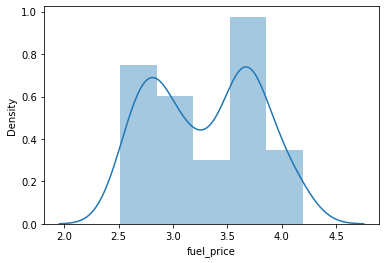

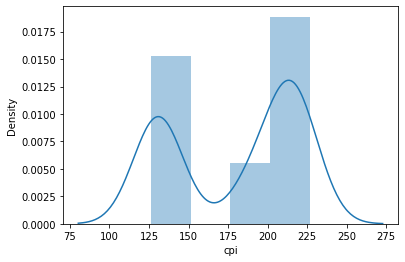

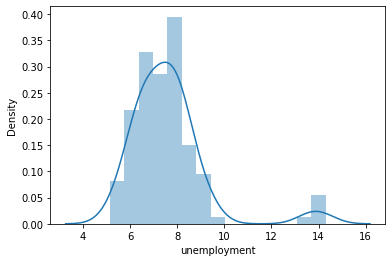

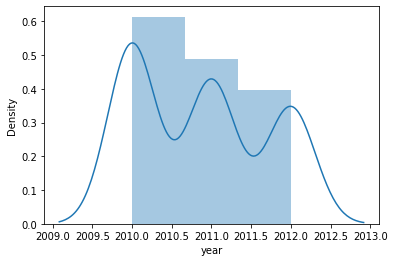

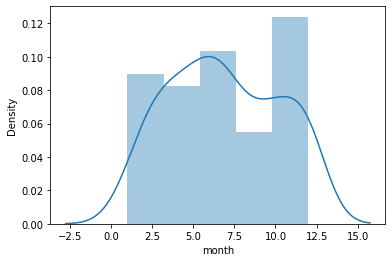

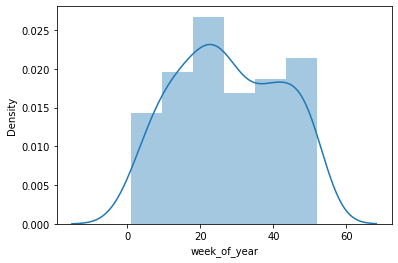

In [ ]:

plt.rcParams['figure.figsize'] = [6, 2]
%matplotlib inline

# sample time series data
df2 = df.copy()
df2.drop(columns = ['store','holiday_flag','month_label','day_of_week'], inplace=True) #categorical columns

# create distplots
for c in df2.columns:
    plt.figure()             # <==================== here!
    sns.distplot(df2[c])

In [ ]:
# Conclusion : It should make sense to drop outliers in the unemployment column.
#Scaling the data will be necessary

# Plot pairwise relationships in the dataset

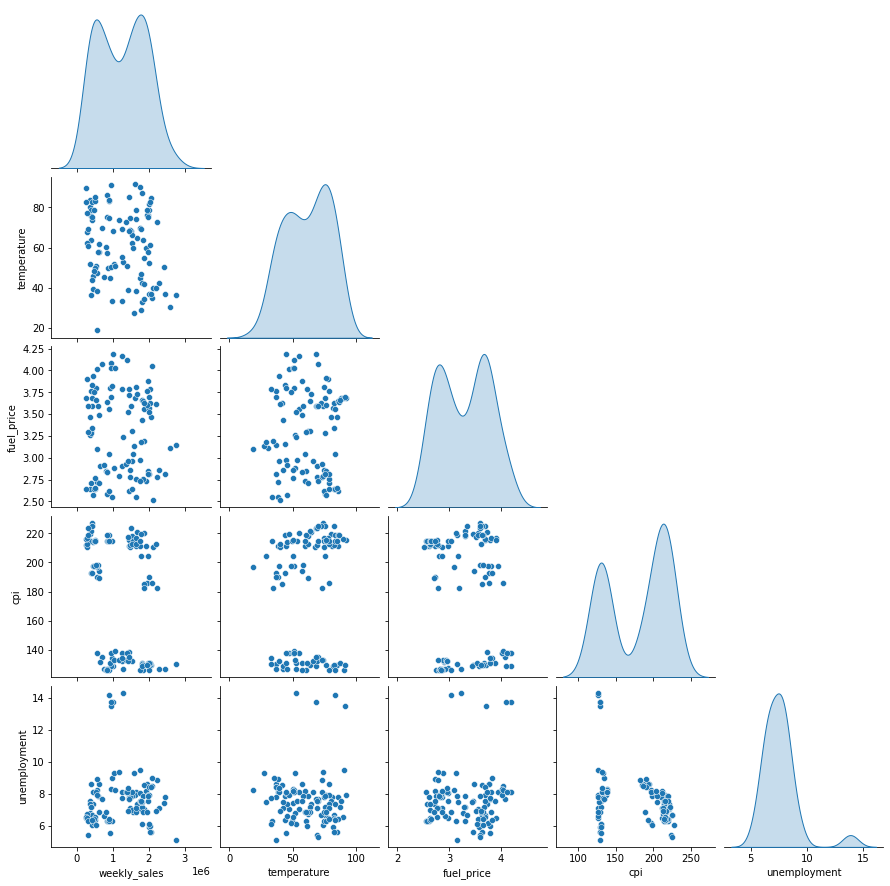

In [ ]:

sns.pairplot(df[['weekly_sales', 'temperature',
       'fuel_price', 'cpi', 'unemployment']],corner=True, diag_kind="kde");

In [ ]:
df.columns

Index(['store', 'date', 'weekly_sales', 'holiday_flag', 'temperature',
       'fuel_price', 'cpi', 'unemployment', 'year', 'month', 'month_label',
       'day_of_week', 'week_of_year'],
      dtype='object')



---



# **Part II Preprocessing & model selection**

# Detection of highly correlated features

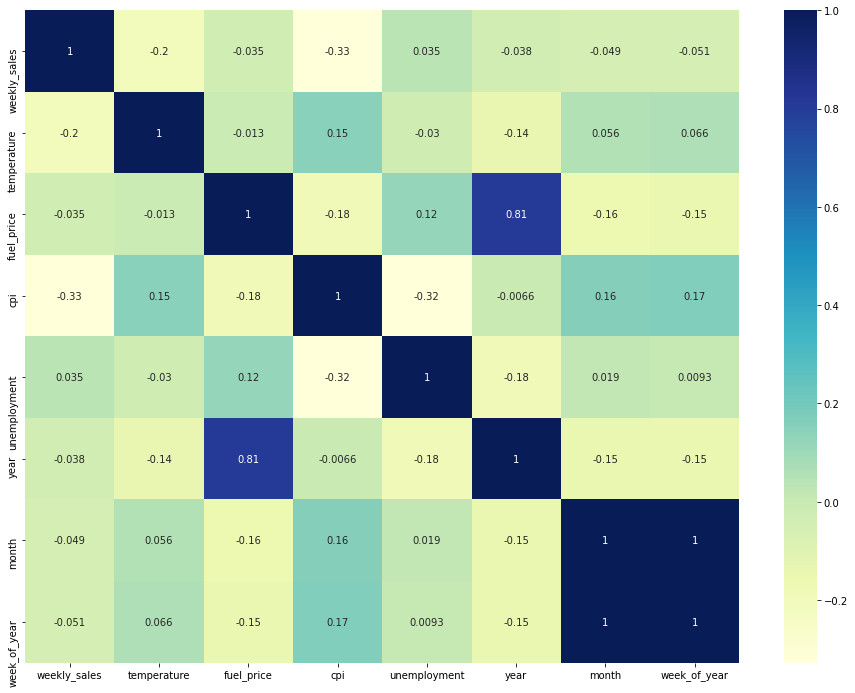

In [ ]:
# Plotting a matrix correlation of features
corr = df.corr()
plt.figure(figsize=(16,12))
sns.heatmap(corr, annot=True, cmap='YlGnBu');

In [ ]:
#Let's identify most correlated features :
correlations = corr.unstack().reset_index()
correlations = correlations.rename(columns=dict(zip(correlations.columns, ['feature1', 'feature2', 'coeff'])))
correlations['coeff'] = correlations['coeff'].apply(lambda x : abs(x))

#Filtering features with a high correlation : 
correlations[(correlations.coeff !=1) &  (correlations.coeff > 0.8)].drop_duplicates(subset=['coeff'])


,feature1,feature2,coeff
21,fuel_price,year,0.810191
55,month,week_of_year,0.996446


In [ ]:
#Conclusion : let's drop the month which appear to be to much correlated with the week of year !
df.drop('month', axis=1, inplace=True)


# Outliers detection

We drop lines containing invalid values or outliers : In this project, will be considered as outliers all the numeric features that don't fall within the range :  [X¯−3σ,X¯+3σ] . This concerns the columns : Temperature, Fuel_price, CPI and Unemployment

In [ ]:
for i in ['temperature', 'fuel_price', 'cpi', 'unemployment']:
  df = df[~(np.abs(df[i]-df[i].mean()) > (3*df[i].std()))]
  

In [ ]:
df.shape

(127, 13)

# Pipelines

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127 entries, 44 to 71
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   store         127 non-null    object        
 1   date          127 non-null    datetime64[ns]
 2   weekly_sales  113 non-null    float64       
 3   holiday_flag  127 non-null    object        
 4   temperature   114 non-null    float64       
 5   fuel_price    114 non-null    float64       
 6   cpi           117 non-null    float64       
 7   unemployment  115 non-null    float64       
 8   year          127 non-null    int64         
 9   month         127 non-null    int64         
 10  month_label   127 non-null    object        
 11  day_of_week   127 non-null    object        
 12  week_of_year  127 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(2), object(4)
memory usage: 13.9+ KB


In [ ]:
# Missing values
100* df.isnull().sum().sort_values(ascending=False) / df.shape[0]

weekly_sales    11.023622
fuel_price      10.236220
temperature     10.236220
unemployment     9.448819
cpi              7.874016
week_of_year     0.000000
day_of_week      0.000000
month_label      0.000000
month            0.000000
year             0.000000
holiday_flag     0.000000
date             0.000000
store            0.000000
dtype: float64

Droping lines where target values are missing :

The target variable (Y) corresponds to the column Weekly_Sales. One can see above that there are some missing values in this column.
We never use imputation techniques on the target : it might create some bias in the predictions !
Then, we just drop the lines in the dataset for which the value in Weekly_Sales is missing.

In [ ]:
df.dropna(subset=['weekly_sales'], inplace=True)

In [ ]:
# Converting date to unix
df['date'] = df.date.apply(lambda x: int(x.strftime("%s")))


Splitting features & target

In [ ]:
target = 'weekly_sales'

X = df.loc[:, df.columns != target]
Y = df.loc[:,target] 

Y = Y.apply(lambda x: float(x[1:]) if type(x)==str else x)

#Split the data into a train set and test set 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)


# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.tolist()
Y_test = Y_test.tolist()
print("...Numpy conversion to arrays Done !")


Convert pandas DataFrames to numpy arrays...
...Numpy conversion to arrays Done !


Automatically detect positions of numeric/categorical features : 

In [ ]:
idx = 0
numeric_features = []
numeric_indices = []
categorical_features = []
categorical_indices = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
        numeric_indices.append(idx)
    else :
        categorical_features.append(i)
        categorical_indices.append(idx)

    idx = idx + 1

print('Found numeric features ', numeric_features,' at positions ', numeric_indices)
print('Found categorical features ', categorical_features,' at positions ', categorical_indices)

Found numeric features  ['date', 'temperature', 'fuel_price', 'cpi', 'unemployment', 'year', 'month', 'week_of_year']  at positions  [1, 3, 4, 5, 6, 7, 8, 11]
Found categorical features  ['store', 'holiday_flag', 'month_label', 'day_of_week']  at positions  [0, 2, 9, 10]


In [ ]:
from missingpy import KNNImputer
imputer = KNNImputer()

numeric_transformer = Pipeline(steps=[
    ('imputer',KNNImputer()),
    ('scaler',StandardScaler()) 
])
#StandardScaler()
# Create pipeline for categorical features

categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_indices),
        ('cat', categorical_transformer, categorical_indices)
    ])

# Preprocessings on train set
print("Performing preprocessings on train set...")
X_train = preprocessor.fit_transform(X_train)
print('preprocessings on train set...Done.')


# Preprocessings on test set
print("Performing preprocessings on test set...")
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('preprocessings on test set...Done.')


Performing preprocessings on train set...
preprocessings on train set...Done.
Performing preprocessings on test set...
preprocessings on test set...Done.



# **# PART II : Models fitting**

In [ ]:
#Instanciate models
lin = LinearRegression()
lasso1000 = Lasso(alpha = 1000)
lasso2000= Lasso(alpha = 2000)
lasso500 = Lasso(alpha =500)
ridge_regressor_small_alpha = Ridge(alpha = 0)
ridge_regressor_big_alpha = Ridge(alpha = 1)
regressor_ada = AdaBoostRegressor(lin)
regressor_xgb = XGBRegressor()
regressor_random_forrest = RandomForestRegressor(max_depth=4, random_state=42)
tree_regressor = DecisionTreeRegressor()
bagging_regressor = BaggingRegressor(n_estimators=40)
gbr = GradientBoostingRegressor(learning_rate=0.5,n_estimators=40)

# m = Prophet()

In [ ]:

#from sklearn.metrics import classification_report #pas utilisé
classifier = []
for model in [lin,lasso1000, lasso2000, lasso500, ridge_regressor_small_alpha, ridge_regressor_big_alpha, regressor_ada, regressor_xgb, regressor_random_forrest,tree_regressor, bagging_regressor, gbr ]:
  model.fit(X_train, Y_train)
  Y_train_pred    = model.predict(X_train)
  Y_test_pred     = model.predict(X_test)
  score           = model.score(X_test, Y_test)

  r2_score_train  = r2_score(Y_train, Y_train_pred)
  r2_score_test   = r2_score(Y_test, Y_test_pred)
  
  mae_train       = round(mean_absolute_error(Y_train, Y_train_pred) /1000)
  mean_squared_error_train = round(np.sqrt(mean_squared_error(Y_train, Y_train_pred)))
  mean_squared_error_test = round(np.sqrt(mean_squared_error(Y_test, Y_test_pred)))
  mae_test= round(mean_absolute_error(Y_test, Y_test_pred) / 1000) #pour lisibilité

#for classification only

  # accuracy_train  = accuracy_score(Y_train, Y_train_pred)
  # accuracy_test = accuracy_score(Y_test, Y_test_pred)
  # f1_score_train =f1_score(Y_train, Y_train_pred)
  # f1_score_test = f1_score(Y_test, Y_test_pred)

  

  classifier.append({'classifier'     : model,
                    'score'           : score,
                    'r2_score_train'  : r2_score_train,
                     'r2_score_test'  : r2_score_test,
                     'mae_train / 1000'      : mae_train,
                     'mae_test / 1000'       : mae_test,
                     'rmse_train' : mean_squared_error_train,
                     'rmse_test' : mean_squared_error_test
                    # 'accuracy_train' : accuracy_train,
                    # 'accuracy_test' : accuracy_test,
                    # 'f1_score_train' : f1_score_train,
                    # 'f1_score_test' : f1_score_test
                     }
                    )

[17:47:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
all_scores = pd.DataFrame.from_dict(classifier)
all_scores.sort_values(by='r2_score_test', ascending=False).reset_index().drop(columns=['index'])

,classifier,score,r2_score_train,r2_score_test,mae_train / 1000,mae_test / 1000,rmse_train,rmse_test
0,"Lasso(alpha=1000, copy_X=True, fit_intercept=T...",0.932723,0.971956,0.932723,80,118,111020,171915
1,"Lasso(alpha=500, copy_X=True, fit_intercept=Tr...",0.929031,0.974808,0.929031,80,121,105223,176568
2,"Lasso(alpha=2000, copy_X=True, fit_intercept=T...",0.925772,0.964681,0.925772,85,123,124590,180577
3,"Ridge(alpha=0, copy_X=True, fit_intercept=True...",0.913762,0.975918,0.913762,82,131,102879,194637
4,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.913317,0.975925,0.913317,81,131,102864,195140
5,"(LinearRegression(copy_X=True, fit_intercept=T...",0.893136,0.996001,0.893136,31,143,41922,216668
6,"Ridge(alpha=1, copy_X=True, fit_intercept=True...",0.888069,0.930408,0.888069,137,192,174889,221745
7,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",0.767963,0.999659,0.767963,10,243,12248,319269
8,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.672850,0.977313,0.672850,76,299,99856,379098
9,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0.513430,0.945046,0.513430,118,369,155411,462329


# **# Part III : Let's try to minimize the overfitting**

In [ ]:
gridsearch = GridSearchCV(
    Lasso(), {'alpha': [910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090]}, cv=3)
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best R2 score : ", gridsearch.best_score_)

Y_test_pred = gridsearch.predict(X_test)
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

mae_test= round(mean_absolute_error(Y_test, Y_test_pred) / 1000) #pour lisibilité
print("MAE Test score / 1000: ",mae_test)

...Done.
Best hyperparameters :  {'alpha': 940}
Best R2 score :  0.8943602711375244
R2 score on training set :  0.9996586934416916
R2 score on test set :  0.9320191822165182
MAE Test score / 1000:  119


In [ ]:
gridsearch.best_estimator_

Lasso(alpha=940, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
model = gridsearch.best_estimator_
model.fit(X_train, Y_train)
model.coef_


array([    6161.58605406,   -25318.1112102 ,   -28614.56812816,
          58387.80030929,   -29960.82764335,        0.        ,
          40486.87858548,   446735.85387265,   176049.16685804,
         515680.68812398,   583746.44217609,  -721425.02980735,
       -1019535.90212676,  -614236.75831628,  -269505.20024421,
             -0.        ,   222234.09392831,   368427.13161769,
       -1148304.83557663,   668262.29321825, -1258854.77508833,
              0.        ,  -959472.3410871 ,  -730744.38373227,
       -1065717.11222204,   121165.1071701 ,    64591.99051384,
             -0.        ,    66744.37547257,    91157.24669754,
             -0.        ,   -51590.64869862,    19261.83442646,
          30167.43160442,        0.        ,       -0.        ,
          25148.47592879,   -73220.08723249,   -63950.86119761,
         -26382.86794359,    85609.16764295,        0.        ,
         155312.53244184])

In [ ]:
preprocessed_features = numeric_features
cat_features_preprocessed = preprocessor.transformers_[1][1][1].get_feature_names()

preprocessed_features +=cat_features_preprocessed.tolist()
print(preprocessed_features)

['date', 'temperature', 'fuel_price', 'cpi', 'unemployment', 'year', 'week_of_year', 'x0_store_10', 'x0_store_11', 'x0_store_13', 'x0_store_14', 'x0_store_15', 'x0_store_16', 'x0_store_17', 'x0_store_18', 'x0_store_19', 'x0_store_2', 'x0_store_20', 'x0_store_3', 'x0_store_4', 'x0_store_5', 'x0_store_6', 'x0_store_7', 'x0_store_8', 'x0_store_9', 'x1_regular', 'x1_unknown', 'x2_August', 'x2_December', 'x2_February', 'x2_January', 'x2_July', 'x2_June', 'x2_March', 'x2_May', 'x2_November', 'x2_October', 'x2_September', 'x3_Monday', 'x3_Saturday', 'x3_Sunday', 'x3_Thursday', 'x3_Tuesday']


In [ ]:
removed_features = np.array(preprocessed_features)[(model.coef_ == 0)]
removed_features

array(['year', 'x0_store_19', 'x0_store_6', 'x2_August', 'x2_January',
       'x2_May', 'x2_November', 'x3_Thursday'], dtype='<U12')

One can wonder about the relevance of removing some stores, some months or a day (...)

<AxesSubplot:ylabel='features'>

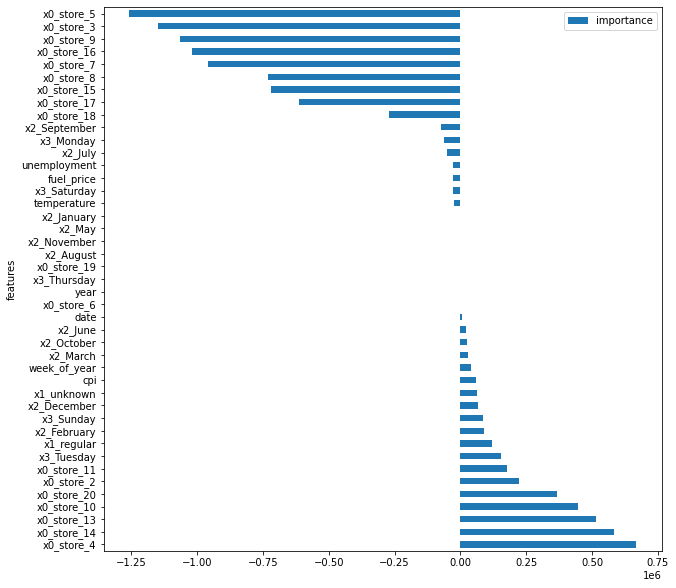

In [ ]:
all_coef_importance = pd.DataFrame()
all_coef_importance['features'] = preprocessed_features
all_coef_importance['importance'] = model.coef_
all_coef_importance.sort_values(by='importance', ascending=False).plot(x = 'features', y='importance',kind = 'barh', figsize=(10, 10))

# **A gridsearchcv does not significantly improve the results since the R2 score on test set: goes from 0.932014 to 0.932019**


# Cross-validated score for a Ridge model 

In [ ]:
# Perform 3-fold cross-validation to evaluate the generalized R2 score obtained with a Ridge model
print("3-fold cross-validation...")
regressor = Ridge()
params = {
    'alpha': [ 0.05,0.06,0.07,0.08,0.09,0.1] # 0 corresponds to no regularization
}
gridsearch = GridSearchCV(regressor, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
scores = cross_val_score(regressor, X_train, Y_train, cv=3)

print("Best hyperparameters : ", gridsearch.best_params_)
print("Best R2 score : ", gridsearch.best_score_)

Y_test_pred = gridsearch.predict(X_test)
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

3-fold cross-validation...
Best hyperparameters :  {'alpha': 0.07}
Best R2 score :  0.8768902593732183
R2 score on training set :  0.9996586934416916
R2 score on test set :  0.9174204989431481


Removed features :  []


<AxesSubplot:ylabel='features'>

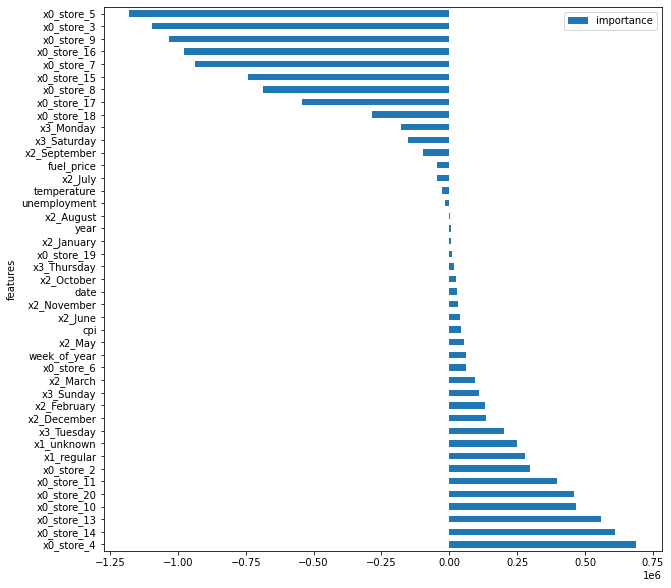

In [ ]:
model = gridsearch.best_estimator_
model.fit(X_train, Y_train)
model.coef_
preprocessed_features = numeric_features
cat_features_preprocessed = preprocessor.transformers_[1][1][1].get_feature_names()

preprocessed_features +=cat_features_preprocessed.tolist()

all_coef_importance = pd.DataFrame()
all_coef_importance['features'] = preprocessed_features
all_coef_importance['importance'] = model.coef_
all_coef_importance.sort_values(by='importance', ascending=False).plot(x = 'features', y='importance',kind = 'barh', figsize=(10, 10))

**A gridsearchcv with ridge model does neither significantly improve the results**

## Last but not least : let's do a test to see if inflation, temperature, and unemployement data drive accurate results

In [ ]:
X = df.loc[:, df.columns.isin(['holiday_flag', 'temperature',
       'fuel_price', 'cpi', 'unemployment','week_of_year'])]

Y = df.loc[:,target] 

Y = Y.apply(lambda x: float(x[1:]) if type(x)==str else x)

#Split the data into a train set and test set 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)


# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.tolist()
Y_test = Y_test.tolist()
print("...Numpy conversion to arrays Done !")

Convert pandas DataFrames to numpy arrays...
...Numpy conversion to arrays Done !


In [ ]:
idx = 0
numeric_features = []
numeric_indices = []
categorical_features = []
categorical_indices = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
        numeric_indices.append(idx)
    else :
        categorical_features.append(i)
        categorical_indices.append(idx)

    idx = idx + 1

print('Found numeric features ', numeric_features,' at positions ', numeric_indices)
print('Found categorical features ', categorical_features,' at positions ', categorical_indices)

Found numeric features  ['temperature', 'fuel_price', 'cpi', 'unemployment', 'week_of_year']  at positions  [1, 2, 3, 4, 5]
Found categorical features  ['holiday_flag']  at positions  [0]


In [ ]:
from missingpy import KNNImputer
imputer = KNNImputer()

numeric_transformer = Pipeline(steps=[
    ('imputer',KNNImputer()),
    ('scaler',StandardScaler()) 
])
#StandardScaler()
# Create pipeline for categorical features

categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_indices),
        ('cat', categorical_transformer, categorical_indices)
    ])

# Preprocessings on train set
print("Performing preprocessings on train set...")
X_train = preprocessor.fit_transform(X_train)
print('preprocessings on train set...Done.')


# Preprocessings on test set
print("Performing preprocessings on test set...")
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('preprocessings on test set...Done.')


Performing preprocessings on train set...
preprocessings on train set...Done.
Performing preprocessings on test set...
preprocessings on test set...Done.


In [ ]:
#Instanciate models
lin = LinearRegression()
lasso1000 = Lasso(alpha = 1000)
lasso2000= Lasso(alpha = 2000)
lasso500 = Lasso(alpha =500)
ridge_regressor_small_alpha = Ridge(alpha = 0)
ridge_regressor_big_alpha = Ridge(alpha = 1)
regressor_ada = AdaBoostRegressor(lin)
regressor_xgb = XGBRegressor()
regressor_random_forrest = RandomForestRegressor(max_depth=4, random_state=42)
tree_regressor = DecisionTreeRegressor()
bagging_regressor = BaggingRegressor(n_estimators=40)
gbr = GradientBoostingRegressor(learning_rate=0.5,n_estimators=40)

In [ ]:

#from sklearn.metrics import classification_report #pas utilisé
classifier = []
for model in [lin,lasso1000, lasso2000, lasso500, ridge_regressor_small_alpha, ridge_regressor_big_alpha, regressor_ada, regressor_xgb, regressor_random_forrest,tree_regressor, bagging_regressor, gbr ]:
  model.fit(X_train, Y_train)
  Y_train_pred    = model.predict(X_train)
  Y_test_pred     = model.predict(X_test)
  score           = model.score(X_test, Y_test)

  r2_score_train  = r2_score(Y_train, Y_train_pred)
  r2_score_test   = r2_score(Y_test, Y_test_pred)
  
  mae_train       = round(mean_absolute_error(Y_train, Y_train_pred) /1000)
  mean_squared_error_train = round(np.sqrt(mean_squared_error(Y_train, Y_train_pred)))
  mean_squared_error_test = round(np.sqrt(mean_squared_error(Y_test, Y_test_pred)))
  mae_test= round(mean_absolute_error(Y_test, Y_test_pred) / 1000) #pour lisibilité

#for classification only

  # accuracy_train  = accuracy_score(Y_train, Y_train_pred)
  # accuracy_test = accuracy_score(Y_test, Y_test_pred)
  # f1_score_train =f1_score(Y_train, Y_train_pred)
  # f1_score_test = f1_score(Y_test, Y_test_pred)

  

  classifier.append({'classifier'     : model,
                    'score'           : score,
                    'r2_score_train'  : r2_score_train,
                     'r2_score_test'  : r2_score_test,
                     'mae_train / 1000'      : mae_train,
                     'mae_test / 1000'       : mae_test,
                     'rmse_train' : mean_squared_error_train,
                     'rmse_test' : mean_squared_error_test
                    # 'accuracy_train' : accuracy_train,
                    # 'accuracy_test' : accuracy_test,
                    # 'f1_score_train' : f1_score_train,
                    # 'f1_score_test' : f1_score_test
                     }
                    )

[18:21:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
all_scores = pd.DataFrame.from_dict(classifier)
all_scores.sort_values(by='r2_score_test', ascending=False).reset_index().drop(columns=['index'])

,classifier,score,r2_score_train,r2_score_test,mae_train / 1000,mae_test / 1000,rmse_train,rmse_test
0,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",-0.027173,0.724454,-0.027173,280,599,347999,671738
1,"XGBRegressor(base_score=0.5, booster='gbtree',...",-0.063291,0.961699,-0.063291,96,547,129743,683446
2,"Lasso(alpha=2000, copy_X=True, fit_intercept=T...",-0.075286,0.155536,-0.075286,544,633,609217,687290
3,"Ridge(alpha=1, copy_X=True, fit_intercept=True...",-0.076034,0.155635,-0.076034,544,634,609181,687529
4,"Lasso(alpha=1000, copy_X=True, fit_intercept=T...",-0.076791,0.155671,-0.076791,543,633,609168,687771
5,"Lasso(alpha=500, copy_X=True, fit_intercept=Tr...",-0.077560,0.155705,-0.077560,543,633,609155,688017
6,"Ridge(alpha=0, copy_X=True, fit_intercept=True...",-0.078339,0.155716,-0.078339,543,634,609151,688265
7,"LinearRegression(copy_X=True, fit_intercept=Tr...",-0.078339,0.155716,-0.078339,543,634,609151,688265
8,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",-0.091277,0.904299,-0.091277,167,599,205087,692382
9,"(LinearRegression(copy_X=True, fit_intercept=T...",-0.109345,0.138841,-0.109345,545,634,615209,698090


Conclusion : the test scores are extremely bad which proves that it was a very bad idea to restrict the analysis to 'holiday_flag', 'temperature', 'fuel_price', 'cpi', 'unemployment', 'week_of_year' features